In [1]:
import pandas as pd
import numpy as np
import json
import datetime

### Parse Data

In [2]:
def find_review_idx(chunk):
    for i,line in enumerate(chunk):
        if "reviews:" in line:
            return i

def process_review(review):
    split_review = review.split()
    review_dct = {
        "total": int(split_review[2]),
        "downloaded": int(split_review[4]),
        "avg rating": float(split_review[7])
    }
    return split_review[0],review_dct

def process_review_dcts(review_list):
    review_dcts = []
    for line in review_list:
        line_sp = line.split()
        review_dct = {
            "date": datetime.datetime.strptime(line_sp[0], "%Y-%m-%d"), #parse to a date
            "customer": line_sp[2],
            "rating": int(line_sp[4]),
            "votes": int(line_sp[6]),
            "helpful": int(line_sp[8])
        }
        review_dcts.append(review_dct)
    return review_dcts

def process_chunk(chunk):

    ID,id_val = chunk[0].split(":")
    ASIN,asin_val = chunk[1].split(":")
    if len(chunk) > 7:
        review_idx = find_review_idx(chunk)
        title_lst = chunk[2].split(":")
        group,grp_val = chunk[3].split(":")
        salesrank,sales_val = chunk[4].split(":")
        similar,similar_val = chunk[5].split(":")
        similar_val_lst = similar_val.split()
        categories,cat_num = chunk[6].split(":")
        cat_list = list(map(lambda x: x.strip("\n").strip(), chunk[7:review_idx]))
        reviews,review_dct = process_review(chunk[review_idx])
        review_dcts = process_review_dcts(chunk[review_idx+1:])
            
        chunk_json = {
            ID : int(id_val),
            ASIN : asin_val.strip(),
            title_lst[0].strip() : ":".join(title_lst[1:]).strip("\n"),
            group.strip() : grp_val.strip().strip("\n"),
            salesrank.strip() : int(sales_val),
            similar.strip() : similar_val_lst[0],
            "similar_lst": similar_val_lst[1:],
            categories.strip() : int(cat_num),
            "category_lst": cat_list,
            reviews: review_dct,
            "review_lst": review_dcts
        }
    else:
        chunk_json = {
            ID : int(id_val),
            ASIN : asin_val.strip()
        }
        
    return chunk_json

current_chunk = []
chunks = []

with open('amazon-meta.txt', 'r', encoding="utf8") as f:
    f.readline()
    f.readline()
    for line in f:
        if line == '\n' and current_chunk != []:
            chunks.append(process_chunk(current_chunk))
            current_chunk = []
        elif line != '\n':
            current_chunk.append(line)

chunks[:5]

[{'ASIN': '0771044445', 'Id': 0},
 {'ASIN': '0827229534',
  'Id': 1,
  'categories': 2,
  'category_lst': ['|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Preaching[12368]',
   '|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Sermons[12370]'],
  'group': 'Book',
  'review_lst': [{'customer': 'A2JW67OY8U6HHK',
    'date': datetime.datetime(2000, 7, 28, 0, 0),
    'helpful': 9,
    'rating': 5,
    'votes': 10},
   {'customer': 'A2VE83MZF98ITY',
    'date': datetime.datetime(2003, 12, 14, 0, 0),
    'helpful': 5,
    'rating': 5,
    'votes': 6}],
  'reviews:': {'avg rating': 5.0, 'downloaded': 2, 'total': 2},
  'salesrank': 396585,
  'similar': '5',
  'similar_lst': ['0804215715',
   '156101074X',
   '0687023955',
   '0687074231',
   '082721619X'],
  'title': ' Patterns of Preaching: A Sermon Sampler'},
 {'ASIN': '0738700797',
  'Id': 2,
  'categories': 2,
  'category_lst': ['|Books[283155]|Subjects

### Convert to Pandas

In [3]:
from pandas.io.json import json_normalize
df = json_normalize(chunks)

In [4]:
df.head()

,ASIN,Id,categories,category_lst,group,review_lst,reviews:,salesrank,similar,similar_lst,title
0,0771044445,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0827229534,1,2.0,[|Books[283155]|Subjects[1000]|Religion & Spir...,Book,"[{'date': 2000-07-28 00:00:00, 'customer': 'A2...","{'total': 2, 'downloaded': 2, 'avg rating': 5.0}",396585.0,5,"[0804215715, 156101074X, 0687023955, 068707423...",Patterns of Preaching: A Sermon Sampler
2,0738700797,2,2.0,[|Books[283155]|Subjects[1000]|Religion & Spir...,Book,"[{'date': 2001-12-16 00:00:00, 'customer': 'A1...","{'total': 12, 'downloaded': 12, 'avg rating': ...",168596.0,5,"[0738700827, 1567184960, 1567182836, 073870052...",Candlemas: Feast of Flames
3,0486287785,3,1.0,[|Books[283155]|Subjects[1000]|Home & Garden[4...,Book,"[{'date': 2003-07-10 00:00:00, 'customer': 'A3...","{'total': 1, 'downloaded': 1, 'avg rating': 5.0}",1270652.0,0,[],World War II Allied Fighter Planes Trading Cards
4,0842328327,4,5.0,[|Books[283155]|Subjects[1000]|Religion & Spir...,Book,"[{'date': 2004-08-19 00:00:00, 'customer': 'A2...","{'total': 1, 'downloaded': 1, 'avg rating': 4.0}",631289.0,5,"[0842328130, 0830818138, 0842330313, 084232861...",Life Application Bible Commentary: 1 and 2 Ti...


# A. Exploratory Analysis

In [5]:
#explore data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548552 entries, 0 to 548551
Data columns (total 11 columns):
ASIN            548552 non-null object
Id              548552 non-null int64
categories      542684 non-null float64
category_lst    542684 non-null object
group           542684 non-null object
review_lst      542684 non-null object
reviews:        542684 non-null object
salesrank       542684 non-null float64
similar         542684 non-null object
similar_lst     542684 non-null object
title           542684 non-null object
dtypes: float64(2), int64(1), object(8)
memory usage: 46.0+ MB


In [6]:
print('There are', len(df[df['categories'].isnull()]), 'missing values in categories, category_list, group, review_1st, reviews:, salesrank, similar, similar_1st, and title.')

There are 5868 missing values in categories, category_list, group, review_1st, reviews:, salesrank, similar, similar_1st, and title.


In [7]:
#check numbers
df.describe()

,Id,categories,salesrank
count,548552.000000,542684.000000,5.426840e+05
mean,274275.500000,4.624605,4.893243e+05
std,158353.466769,4.450647,5.677230e+05
min,0.000000,0.000000,-1.000000e+00
25%,137137.750000,2.000000,9.074100e+04
50%,274275.500000,4.000000,3.004900e+05
75%,411413.250000,6.000000,6.720688e+05
max,548551.000000,116.000000,3.798351e+06


Ids look fine and there are 116 different categories. For some reason salesrank have a range bewteen -1 & 3798351

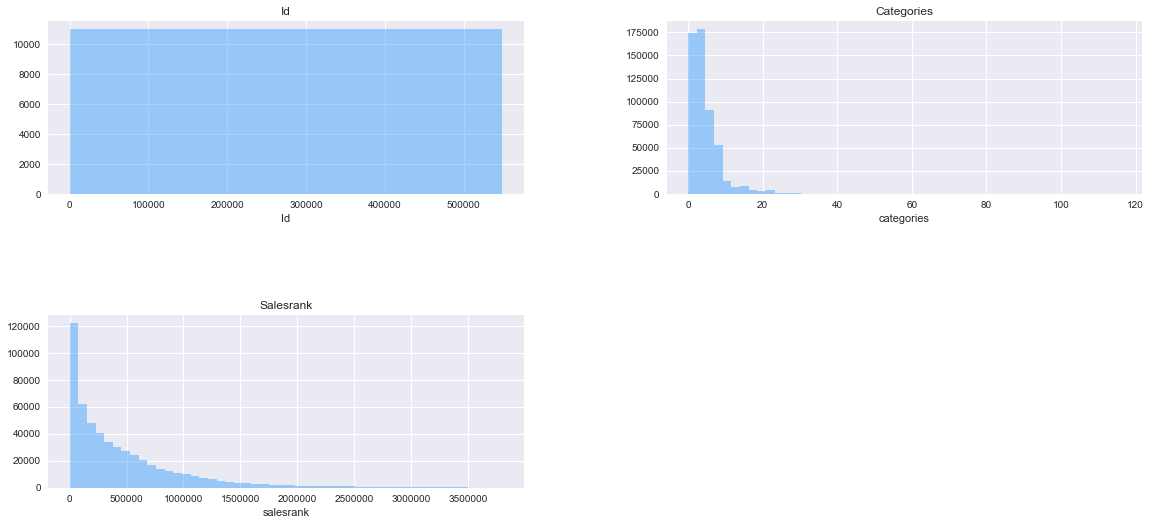

In [8]:
#check distributions
import matplotlib.pyplot as plt
import seaborn as sns

a =plt.subplot(321)
sns.distplot(df[df['Id'].notnull()]['Id'], color='#1e90ff', kde=False)
a.set_title("Id")

b =plt.subplot(322)
sns.distplot(df[df['categories'].notnull()]['categories'], color='#1e90ff', kde=False)
b.set_title("Categories")

c =plt.subplot(323)
sns.distplot(df[df['salesrank'].notnull()]['salesrank'], color='#1e90ff', kde=False)
c.set_title("Salesrank")


plt.subplots_adjust(top=2, bottom=0.08, left=0.10, right=2, hspace=.7, wspace=0.3)
plt.show()

It seems like a lot of products share the same salesrank. The other distributions make sense. Let's check for any outliers using boxplots.

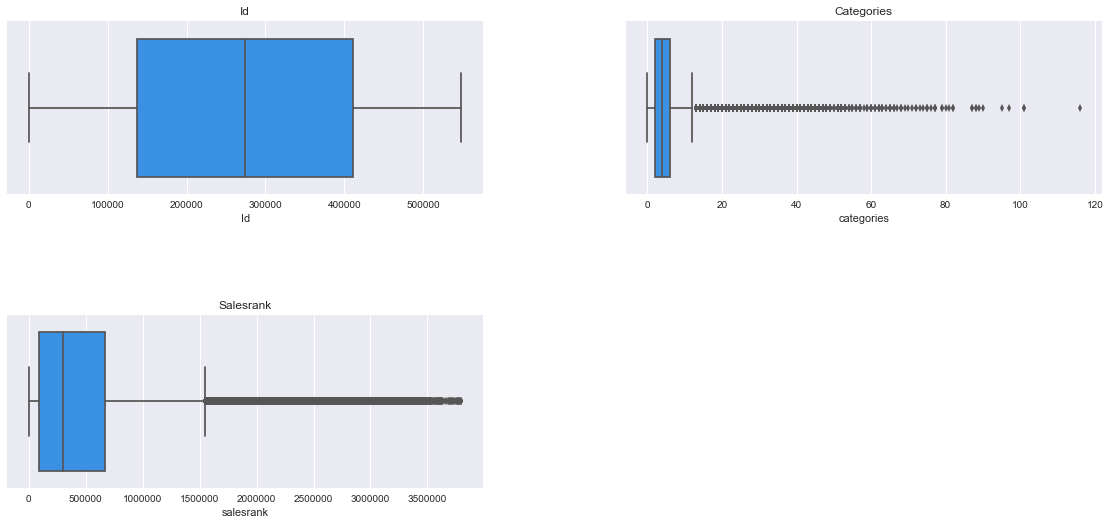

In [9]:
a =plt.subplot(321)
sns.boxplot(x=df[df['Id'].notnull()]['Id'], color='#1e90ff')
a.set_title("Id")

b =plt.subplot(322)
sns.boxplot(x=df[df['categories'].notnull()]['categories'], color='#1e90ff')
b.set_title("Categories")

c =plt.subplot(323)
sns.boxplot(x=df[df['salesrank'].notnull()]['salesrank'], color='#1e90ff')
c.set_title("Salesrank")

plt.subplots_adjust(top=2, bottom=0.08, left=0.10, right=2, hspace=.7, wspace=0.3)
plt.show()

Most of the products fall between 15 and 20 categories, even though there are over 100 categories.

Let's check for categorical columns.

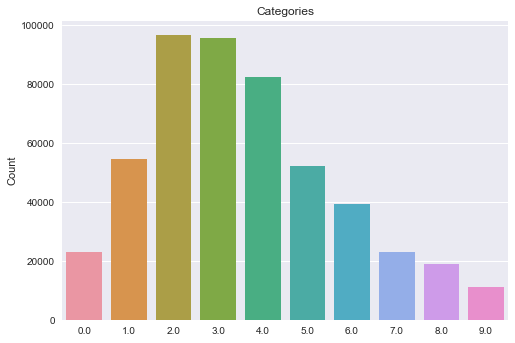

In [10]:
#top categories
a=df['categories'].value_counts().nlargest(10).index
b=df['categories'].value_counts().nlargest(10)
sns.barplot(x=a, y=b)
plt.title('Categories')
plt.ylabel('Count')
plt.show()

In [11]:
for i in range(0,10):
    print(str(i)+" :"+str(df[df['categories']==i]['category_lst'].head(1))[6:])

0 :[]
Name: category_lst, dtype: object
1 :|Books[283155]|Subjects[1000]|Home & Garden[4...
Name: category_lst, dtype: object
2 :|Books[283155]|Subjects[1000]|Religion & Spir...
Name: category_lst, dtype: object
3 :|Music[5174]|Styles[301668]|Jazz[34]|General[...
Name: category_lst, dtype: object
4 :|Books[283155]|Subjects[1000]|Gay & Lesbian[3...
Name: category_lst, dtype: object
5 :|Books[283155]|Subjects[1000]|Religion & Spir...
Name: category_lst, dtype: object
6 :[|Books[283155]|Subjects[1000]|Children's Book...
Name: category_lst, dtype: object
7 :[|Books[283155]|Subjects[1000]|Business & Inve...
Name: category_lst, dtype: object
8 :[|Books[283155]|Subjects[1000]|Business & Inve...
Name: category_lst, dtype: object
9 :[|Books[283155]|Subjects[1000]|Cooking, Food &...
Name: category_lst, dtype: object


The most common categories are Books on subjects of Religion & Sprituality followed by Book on Jazz. All of the top ten categories are books except for category 0. Category 0 does not have a name so it's probably items that do not fall in any category

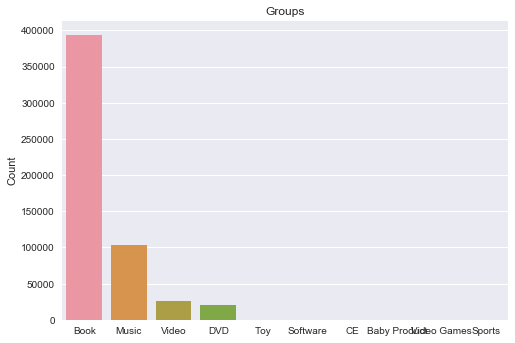

In [12]:
#top groups
a=df['group'].value_counts().nlargest(10).index
b=df['group'].value_counts().nlargest(10)
sns.barplot(x=a, y=b)
plt.title('Groups')
plt.ylabel('Count')
plt.show()

By far the largest group is book with over 350,000 items. Music comes in second followedd by video.

## 1. Trustworthiness of ratings

In [13]:
#Get ratings
ratings=[]
for i in df['reviews:']:
    try:
        ratings.append(i['avg rating'])
    except:
        ratings.append(None)
df['ratings']=ratings

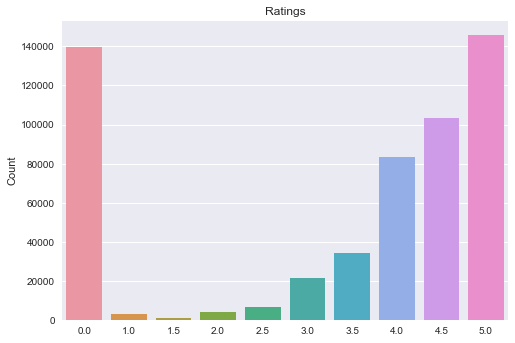

In [14]:
#disply ratings
a=df['ratings'].value_counts().index
b=df['ratings'].value_counts()
sns.barplot(x=a, y=b)
plt.title('Ratings')
plt.ylabel('Count')
plt.show()

Ratings clearly reflect a bias. Most users rate favorably and this makes sense since amazon is fairly popular. A 0 ratings translates to no rating at all.

## 2. Category bloat

#### a. Is there redundancy in the categorization? How can it be identified/removed?

In [15]:
df[df['group']=='Book']['categories'].value_counts()

3.0      77383
2.0      77242
4.0      64866
1.0      43564
5.0      39070
6.0      28819
0.0      18422
7.0      14873
8.0      12477
9.0       5863
10.0      4605
11.0      2357
12.0      1764
13.0       898
14.0       582
15.0       315
16.0       214
17.0       114
18.0        70
19.0        27
20.0        15
23.0         7
21.0         4
22.0         4
26.0         2
24.0         2
34.0         1
116.0        1
Name: categories, dtype: int64

There is some redundancy since there are some categories with only one item. This redundancy can be removed by removing some categories such as category 20, 23, 21, 22, 26, 24, 34, and 116.

#### b. Is it possible to reduce the number of categories drastically (say to 10% of existing categories) by sacrificing relatively few category entries (say close to 10%)?

In [22]:
len(df['categories'].unique())

91

There are 91 unique categories, so we reduce categories by 10%, which is roughly 9 categories.

In [31]:
df['categories'].value_counts().nsmallest(9)

81.0     1
58.0     1
116.0    1
97.0     1
80.0     1
67.0     1
95.0     1
74.0     1
73.0     1
Name: categories, dtype: int64

There are 9 categories with only one item, so it's definitely possible to reduce the number of categories drastically by sacrificing relatively few category entries.

# B.

### 1. Algorithm thinking
##### How would you build the product categorization from scratch, using similar/co-purchased information? 

I would use a Kmeans algorithm to look at clusters of similar purchased items. And based on the appropriate number of clusters, I would name each cluster accordingly based on key words in the products' title.

### 2. Product thinking
#### Now, put on your 'product thinking' hat.

#### a. Is it a good idea to show users the categorization hierarchy for items?

It's a good idea to show product categorization for items to help users find items. However, showing the categorization hierachy may not be a good idea. Items that are in very low categories in the hierachy may be overlooked or ignored. 

#### b. Is it a good idea to show users similar/co-purchased items

This is definitely a good idea because it provides users with recommendations. A user may even find the product he or she was looking in the similar products or even a better product.

#### c. Is it a good idea to show users reviews and ratings for items

Since most of the reviews are positive, it is a good idea to show users ratings for items. It also provides users with more information that allows them to make a good purchasing decision, which in of itself improves the trust the customers have with the company.

#### d. For each of the above, why? How will you establish the same?

Customer satisfaction is extremely important to Amazon. The company understands good customer satisfaction is one the key reasons of the company's success. More informed customers make better purchasing decision and are more likely to be satisfied. So by showing product categories and ratings, Amazon helps its customers make better purchasing decisions.